In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

2024-12-03 15:56:47.242183: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:56:47.268833: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:56:47.269394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 15:56:47.764843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the CSV file
data_path = '/mnt/win_share/GitHub/AI-ethnicity-med-image/data/axial_lung_ct_images.csv'
df = pd.read_csv(data_path)

In [3]:
# Convert any Windows-style paths to Unix-style paths
df['File Location'] = df['File Location'].apply(lambda x: x.replace("\\", "/"))

In [4]:
# Group by 'Subject ID' to handle multiple images per patient
grouped = df.groupby('Subject ID')

# Randomly select one image per patient
df_single_image_per_patient = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Label mapping for converting race categories to integers
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Convert the 'Patient Race' to integer labels
df_single_image_per_patient['Race_Label'] = df_single_image_per_patient['Patient Race'].map(label_mapping)

In [5]:
num_patients = df_single_image_per_patient['Subject ID'].nunique()
num_images = len(df_single_image_per_patient)

# Print the results
print(f"Number of unique patients: {num_patients}")
print(f"Number of images after selecting one per patient: {num_images}")

Number of unique patients: 15639
Number of images after selecting one per patient: 15639


In [6]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    df_single_image_per_patient['File Location'],
    df_single_image_per_patient['Race_Label'],
    test_size=0.2,
    stratify=df_single_image_per_patient['Race_Label'],
    random_state=42
)

In [7]:
# Combine train data into a DataFrame for resampling
train_df = pd.DataFrame({
    'File Location': X_train, 
    'Race_Label': y_train})

In [8]:
# Map integer labels back to race names
race_mapping = {v: k for k, v in label_mapping.items()}
train_df['Patient Race'] = train_df['Race_Label'].map(race_mapping)

In [9]:
# Downsampling and Upsampling Strategy
desired_samples = {
    "White": 2000,  # Downsample to 2000
    "Black or African-American": 1135,  # Upsample
    "Asian": 1135,  # Upsample
    "American Indian or Alaskan Native": 1135,  # Upsample
    "Native Hawaiian or Other Pacific Islander": 1135  # Upsample
}

In [10]:
# Resampling on the training set only
resampled_train_df = pd.DataFrame()

for race, target_count in desired_samples.items():
    # Filter data for the current race
    race_df = train_df[train_df['Patient Race'] == race]
    print(f"\nProcessing race '{race}': {len(race_df)} available samples, target: {target_count}")

    # Resample
    if len(race_df) > target_count:
        # Downsample
        print(f"Downsampling to {target_count}")
        resampled_train_df = pd.concat([resampled_train_df, race_df.sample(target_count, random_state=42)])
    else:
        # Upsample
        print(f"Upsampling to {target_count} (replace=True)")
        resampled_train_df = pd.concat([resampled_train_df, race_df.sample(target_count, replace=True, random_state=42)])

# Reset index for the resampled DataFrame
resampled_train_df = resampled_train_df.reset_index(drop=True)

print("\nResampling complete.")
print(f"Total resampled data: {len(resampled_train_df)} samples")


Processing race 'White': 11548 available samples, target: 2000
Downsampling to 2000

Processing race 'Black or African-American': 467 available samples, target: 1135
Upsampling to 1135 (replace=True)

Processing race 'Asian': 393 available samples, target: 1135
Upsampling to 1135 (replace=True)

Processing race 'American Indian or Alaskan Native': 38 available samples, target: 1135
Upsampling to 1135 (replace=True)

Processing race 'Native Hawaiian or Other Pacific Islander': 65 available samples, target: 1135
Upsampling to 1135 (replace=True)

Resampling complete.
Total resampled data: 6540 samples


In [11]:
# Check class distribution
print("Class distribution after resampling:")
print(resampled_train_df['Patient Race'].value_counts())

Class distribution after resampling:
Patient Race
White                                        2000
Black or African-American                    1135
Asian                                        1135
American Indian or Alaskan Native            1135
Native Hawaiian or Other Pacific Islander    1135
Name: count, dtype: int64


In [12]:
# Change to current directory
os.chdir('/media/yu-tingtseng_sa/16TB IronWolf Pro/Data/NLST/Radiology CT Images/manifest-NLST_allCT')
print(os.getcwd())

/media/yu-tingtseng_sa/16TB IronWolf Pro/Data/NLST/Radiology CT Images/manifest-NLST_allCT


In [13]:
# Preprocess images for model input
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    
    # Ensure only one image per patient (process the first DICOM file found)
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file only
            dicom_path = os.path.join(dicom_folder, dicom_file)
            ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
            img_array = ds.pixel_array  # Extract pixel array

            # Normalize the image
            img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

            # Resize the image
            img = Image.fromarray(img_array)  # Convert to PIL image
            img = img.resize((512, 512))  # Resize to 512x512 pixels
            img_array_resized = np.array(img)  # Convert back to numpy array

            # Convert grayscale image to 3-channel RGB by repeating the single channel 3 times
            img_array_rgb = np.stack([img_array_resized] * 3, axis=-1)

            image_data.append(img_array_rgb)
            processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [14]:
# Preprocess images for training and validation sets (ensure 1 image per patient)
X_train_images, y_train_labels = preprocess_images(resampled_train_df['File Location'], resampled_train_df['Race_Label'])
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

In [15]:
# Check the number of images
num_train_images = X_train_images.shape[0]
num_val_images = X_val_images.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of training images: 6540
Number of validation images: 3128
Number of training labels: 6540
Number of validation labels: 3128


In [16]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


2024-12-03 15:57:27.282369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 15:57:27.282577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-03 15:57:27.316274: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [17]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)  # Fully connected layer
output = Dense(len(label_mapping), activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

In [18]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generator
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=50, 
                    batch_size=32)

# Save the model
# model.save('ethnicity_classification_model.h5')

Epoch 1/50


2024-12-03 15:57:30.300947: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20573061120 exceeds 10% of free system memory.


205/205 [==============================] - ETA: 0s - loss: 1.4275 - accuracy: 0.4312

2024-12-03 16:05:38.375660: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9839837184 exceeds 10% of free system memory.


205/205 [==============================] - 696s 3s/step - loss: 1.4275 - accuracy: 0.4312 - val_loss: 1.4003 - val_accuracy: 0.4066
Epoch 2/50
205/205 [==============================] - 788s 4s/step - loss: 1.1124 - accuracy: 0.5196 - val_loss: 0.9458 - val_accuracy: 0.7084
Epoch 3/50
205/205 [==============================] - 794s 4s/step - loss: 1.0461 - accuracy: 0.5526 - val_loss: 1.0407 - val_accuracy: 0.5748
Epoch 4/50
205/205 [==============================] - 793s 4s/step - loss: 0.9737 - accuracy: 0.5948 - val_loss: 0.8746 - val_accuracy: 0.7433
Epoch 5/50
205/205 [==============================] - 790s 4s/step - loss: 0.9217 - accuracy: 0.6168 - val_loss: 0.7895 - val_accuracy: 0.7858
Epoch 6/50
205/205 [==============================] - 799s 4s/step - loss: 0.8654 - accuracy: 0.6518 - val_loss: 0.6953 - val_accuracy: 0.8296
Epoch 7/50
205/205 [==============================] - 801s 4s/step - loss: 0.8830 - accuracy: 0.6323 - val_loss: 1.2276 - val_accuracy: 0.4054
Epoch 8/50

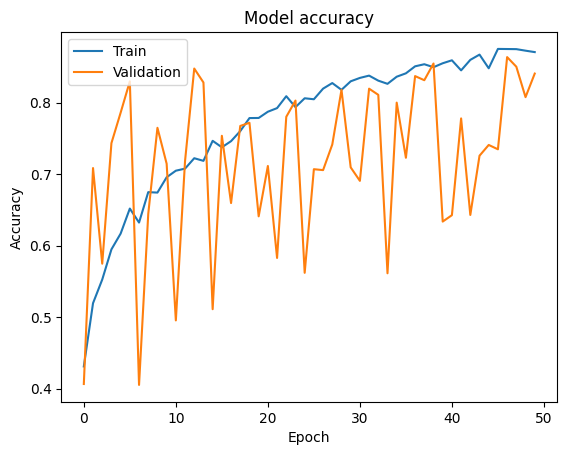

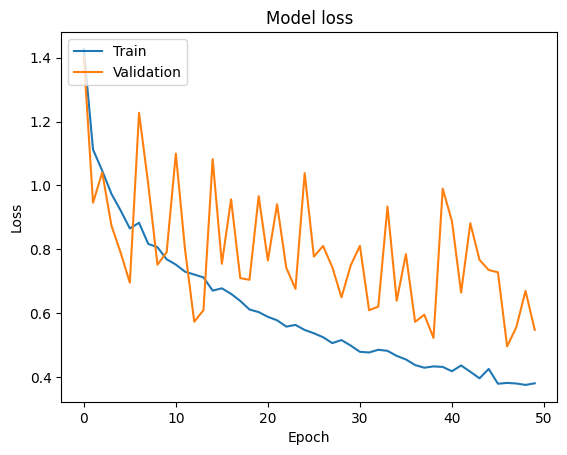

In [19]:
# Plot training & validation accuracy
plt.style.use('default')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [20]:
# Make predictions on the validation set
y_pred = model.predict(X_val_images)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

2024-12-04 02:11:09.681847: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9839837184 exceeds 10% of free system memory.


98/98 [==============================] - 211s 2s/step


Accuracy: 0.8405


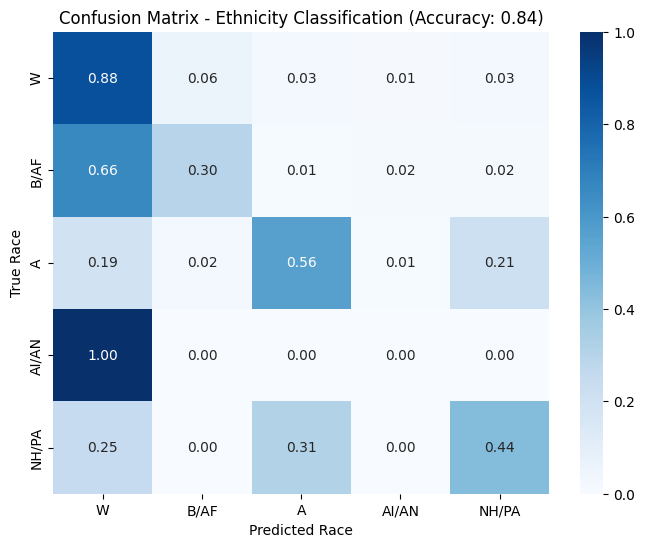

In [21]:
# Create a confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

cma = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define race labels
race_labels = ['W', 'B/AF', 'A', 'AI/AN', 'NH/PA']

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cma, annot=True, fmt='.2f', cmap='Blues', xticklabels=race_labels, yticklabels=race_labels)
plt.xlabel('Predicted Race')
plt.ylabel('True Race')
plt.title(f'Confusion Matrix - Ethnicity Classification (Accuracy: {accuracy:.2f})')
plt.show()

In [22]:
# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_mapping.keys(), zero_division=1))

Classification Report:
                                           precision    recall  f1-score   support

                                    White       0.96      0.88      0.92      2887
                Black or African-American       0.17      0.30      0.22       117
                                    Asian       0.40      0.56      0.46        98
        American Indian or Alaskan Native       0.00      0.00      1.00        10
Native Hawaiian or Other Pacific Islander       0.06      0.44      0.11        16

                                 accuracy                           0.84      3128
                                macro avg       0.32      0.43      0.54      3128
                             weighted avg       0.90      0.84      0.87      3128

